# Statistical Analysis
- Spearman Correlation
- Heatmap Visualization

> **Note:**  
> This notebook uses the **PSEN1_Sun et al.** dataset for correlation analysis and visualization.  
> To analyze a different dataset, update the file path, column names, and figure titles as needed.


In [33]:
# ==============================================================
# 🧩 PSEN1_Sun_et_al Variant Predictors vs. Experimental Outcomes
# Spearman Correlation Analysis + Seaborn Heatmap Visualization
# ==============================================================

In [34]:
# --- 1️⃣ Import Libraries ---
import pandas as pd
import numpy as np
from scipy import stats
from pandas.api.types import CategoricalDtype
import seaborn as sns
import matplotlib.pyplot as plt

# --- 2️⃣ Load Dataset ---
df = pd.read_csv("raw_data/PSEN1_Sun.csv")
df # Display the dataset

,Variants,Mutation,AAO,Total Activity,SD of Total Activity,Ab42/Ab40 ratio,SD of ratio,Amount of Ab40,SD of Ab40,Amount of Ab42,...,DANN_rankscore,fathmm-XF_coding_score,fathmm-XF_coding_rankscore,fathmm-XF_coding_pred,Eigen-raw_coding,Eigen-raw_coding_rankscore,Eigen-phred_coding,Eigen-PC-raw_coding,Eigen-PC-raw_coding_rankscore,Eigen-PC-phred_coding
0,PSEN1:p.Arg35Gln,R35Q,59.0,0.430,0.031,1.449,0.267,0.423,0.032,0.673,...,0.20751,0.361677,0.44935,N,-0.683929,0.16279,0.839981,-0.500256,0.21837,1.201499
1,PSEN1:p.Ala79Val,A79V,61.2,0.013,0.002,NaN,NaN,0.008,0.001,0.056,...,0.98171,0.928313,0.91201,D,0.837492,0.88323,9.558504,0.766865,0.87344,9.212799
2,PSEN1:p.Val82Leu,V82L,55.0,0.596,0.018,0.813,0.070,0.608,0.016,0.516,...,0.91046,0.943348,0.94891,D,0.899956,0.91712,11.048510,0.847559,0.92834,11.683780
3,PSEN1:p.Leu85Pro,L85P,26.0,0.020,0.001,NaN,NaN,0.011,0.001,0.177,...,0.98099,0.966048,0.98840,D,0.907138,0.92061,11.235850,0.825157,0.91439,10.910840
4,PSEN1:p.Val89Leu,V89L,48.6,0.188,0.009,2.526,0.235,0.162,0.006,0.417,...,0.91218,0.945304,0.95328,D,1.007236,0.95941,14.151250,0.930148,0.96740,15.105730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,PSEN1:p.Ala434Cys,A434C,30.3,0.184,0.007,13.448,0.882,0.107,0.002,1.462,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122,PSEN1:p.Leu435Phe,L435F,47.0,0.007,0.001,NaN,NaN,0.003,0.001,0.065,...,0.97953,0.922273,0.89664,D,1.057316,0.97243,15.834650,0.987702,0.98366,18.107830
123,PSEN1:p.Pro436Ser,P436S,47.0,0.165,0.003,8.736,0.338,0.114,0.001,1.013,...,0.96902,0.918603,0.88750,D,1.060208,0.97309,15.939360,0.990907,0.98435,18.295640
124,PSEN1:p.Ile437Val,I437V,57.0,0.133,0.013,4.326,0.548,0.104,0.012,0.441,...,0.49628,0.867801,0.78692,D,-0.006376,0.41303,2.488545,0.099276,0.44238,2.731581


In [35]:
# --- 3️⃣ Identify predictor and outcome columns ---
predictors = [c for c in df.columns if c.endswith('_rankscore')]
outcomes = ["AAO", "Total Activity", "Amount of Ab42", "Amount of Ab40", "Ab42/Ab40 ratio"]
outcomes = [c for c in outcomes if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]

print(f"✅ Using {len(predictors)} predictors and {len(outcomes)} outcomes.\n")

✅ Using 37 predictors and 5 outcomes.



In [36]:
# --- 4️⃣ Define helper function for safe correlation ---
def pairwise_corr(x, y, method="spearman"):
    """Compute correlation safely, ignoring NaNs."""
    mask = np.isfinite(x) & np.isfinite(y)
    n = int(mask.sum())
    if n < 3:
        return np.nan, np.nan, n
    if method == "spearman":
        r, p = stats.spearmanr(x[mask], y[mask])
    else:
        r, p = stats.pearsonr(x[mask], y[mask])
    return r, p, n

# --- 5️⃣ Compute correlations for all predictor–outcome pairs ---
rows = []
for pred in predictors:
    for out in outcomes:
        rho, pval, n = pairwise_corr(df[pred], df[out], method="spearman")
        rows.append({"Predictor": pred, "Outcome": out, "rho": rho, "p_value": pval, "n": n})

corr_df = pd.DataFrame(rows)

In [37]:
# --- 6️⃣ Enforce consistent order (no alphabetical sorting) ---
pred_order = CategoricalDtype(categories=predictors, ordered=True)
out_order = CategoricalDtype(categories=outcomes, ordered=True)
corr_df["Predictor"] = corr_df["Predictor"].astype(pred_order)
corr_df["Outcome"] = corr_df["Outcome"].astype(out_order)
corr_df = corr_df.sort_values(["Outcome", "Predictor"]).reset_index(drop=True)

# --- 7️⃣ Save results ---
output_file = "processed_data/PSEN1_Sun_et_al_correlations.csv" # Change the title as needed
corr_df.to_csv(output_file, index=False)
print(f"📁 Saved correlation results to '{output_file}' ({len(corr_df)} rows).")

📁 Saved correlation results to 'processed_data/PSEN1_Sun_et_al_correlations.csv' (185 rows).


In [38]:
# --- 8️⃣ Pivot to wide format for heatmap ---
rho_matrix = corr_df.pivot(index="Predictor", columns="Outcome", values="rho")

# Optional: reorder predictors by average absolute correlation for nicer structure
row_order = rho_matrix.abs().mean(axis=1).sort_values(ascending=False).index
rho_matrix = rho_matrix.loc[row_order]

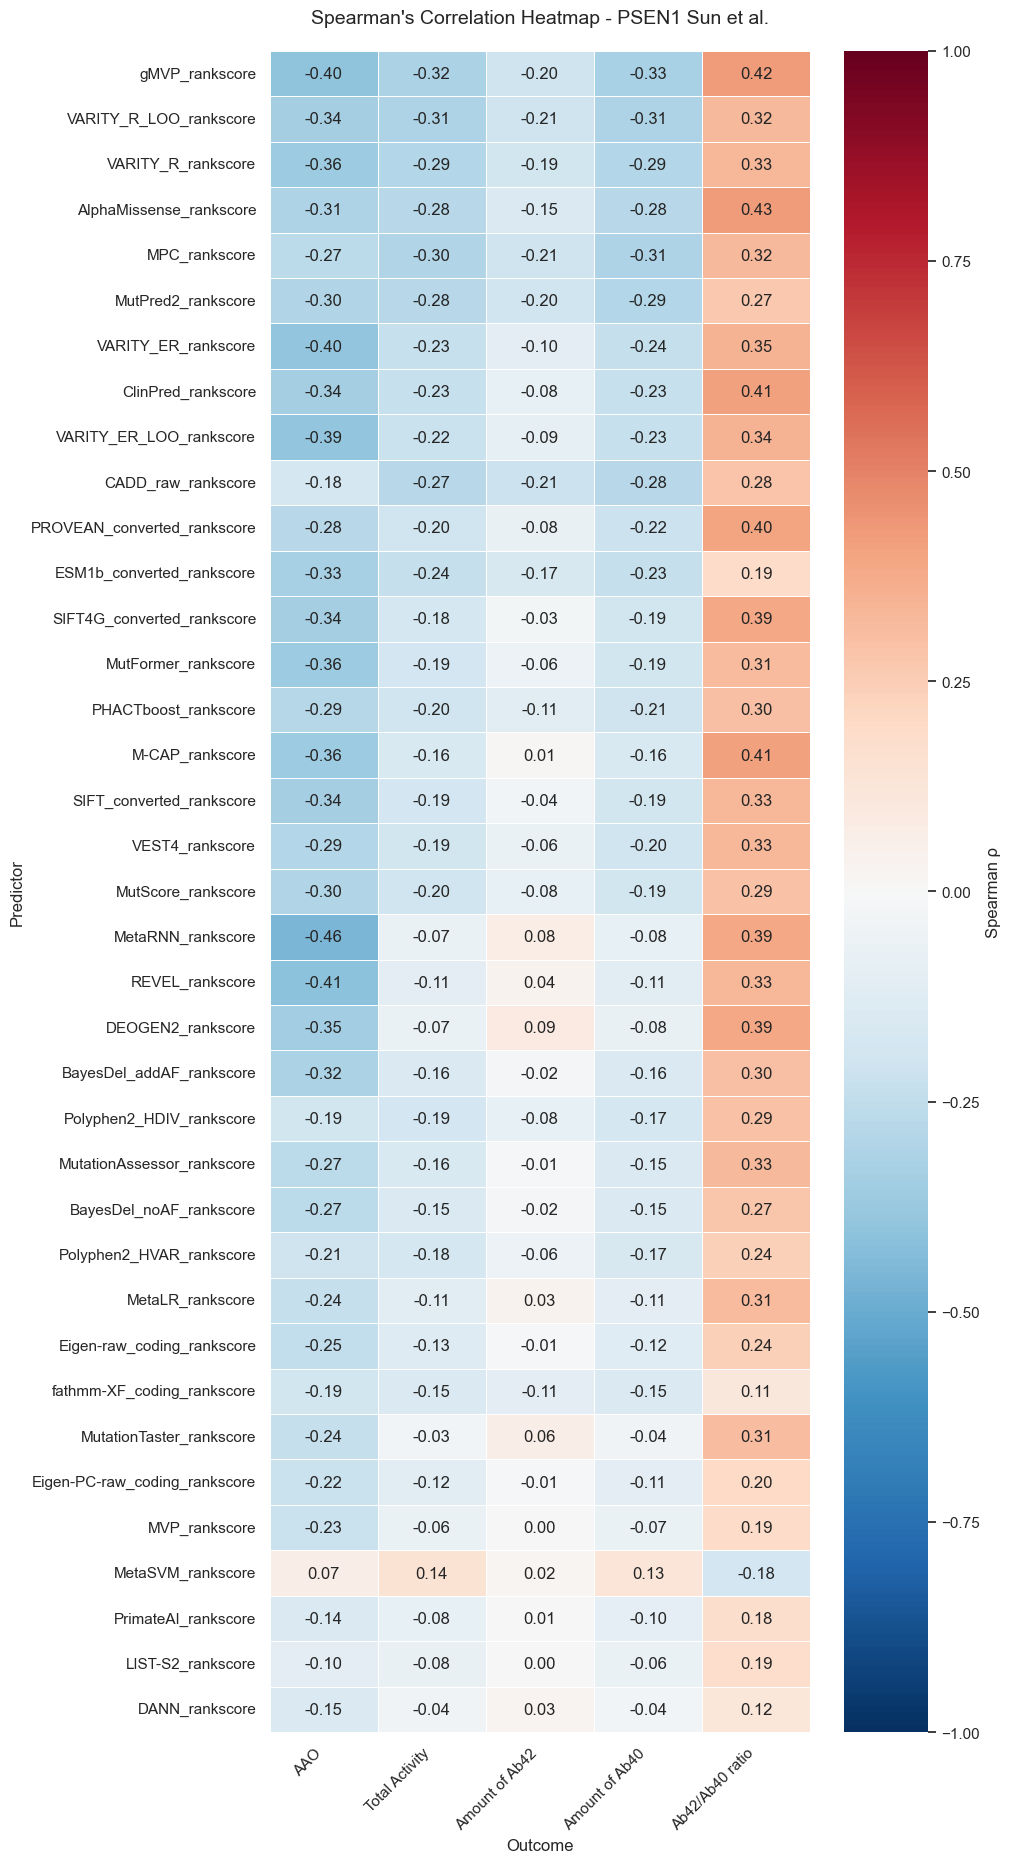

In [39]:
# --- 9️⃣ Plot Spearman Correlation Heatmap ---
sns.set(style='white', font_scale=1.0)

# Create figure & axis handle so we can control saving
fig, ax = plt.subplots(figsize=(10, 0.4 * len(predictors) + 4))

sns.heatmap(
    rho_matrix,
    cmap="RdBu_r",        # red = negative, blue = positive
    vmin=-1, vmax=1,      # color scale range
    annot=True, fmt=".2f",# show numbers
    linewidths=0.5,
    cbar_kws={"label": "Spearman ρ"},
    ax=ax                 # <-- make sure it draws on this axis
)

ax.set_title("Spearman's Correlation Heatmap - PSEN1 Sun et al.", fontsize=14, pad=20) # Change the title as needed
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()


In [40]:
# --- 🔟 Save Figure ---
fig_name = "figures/PSEN1_Sun_heatmap.png"
fig.savefig(fig_name, dpi=600, bbox_inches="tight", facecolor="white")

print(f"📊 Saved heatmap → '{fig_name}' ({len(predictors)} predictors × {len(outcomes)} outcomes)")

📊 Saved heatmap → 'figures/PSEN1_Sun_heatmap.png' (37 predictors × 5 outcomes)
